<a href="https://colab.research.google.com/github/martda08/Tesis-GPJM/blob/main/Cap2/Ejemplo%202.2.4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Ejemplo 2.2.4

*Fecha de última modificación*: 10-oct-22.

*Tesis*: Modelación de la relación entre el cerebro y el comportamiento mediante campos Gaussianos.

*Autor*: Daniela Martínez Aguirre.

*Descripción*: Importancia de la selección adecuada de la función kernel en campos gaussianos para la función  $f$ Seno modificada con tamaño de muestra $n=20$.
	\begin{equation*}
		f(x)=\left\lbrace\begin{array}{c} \sin(x)+5,~3 < x < 5\\ \sin(x), ~~~~~otro~caso. \end{array}\right.
	\end{equation*}

*Figuras*: 2.10 y 2.11.

In [ ]:
#Carga de librerías necesarias 
from typing import Tuple, Optional
import tempfile
import pathlib

import datetime
import io
import matplotlib.pyplot as plt

import numpy as np
import tensorflow as tf

#Versión utilizada agosto 2022 2.5.2
!pip install gpflow==2.5.2
import gpflow

from gpflow.config import default_float
#from gpflow.ci_utils import ci_niter
from gpflow.utilities import to_default_float
from gpflow.utilities import print_summary
import warnings

warnings.filterwarnings("ignore")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 383 kB 6.2 MB/s 
     |████████████████████████████████| 104 kB 49.0 MB/s 


#Simulación de los datos

In [ ]:
#Definimos parámetros iniciales
gpflow.config.set_default_float(np.float64)

#valor de la varianza
sigma=.1

#Tamaño de muestra
num_train_data=20
#Definamos una semilla
np.random.seed(num_train_data)
tf.random.set_seed(num_train_data)

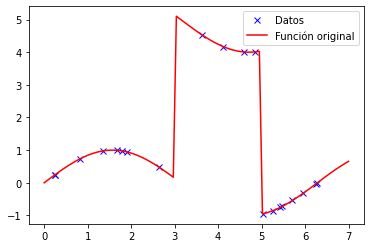

In [ ]:
#Definición del las funciones a estimar

#Función para los ejemplos 2.2.2, 2.2.3 y 2.2.5
def noisy_sin(x):
    return tf.math.sin(x) + np.sqrt(sigma)*tf.random.normal(x.shape,stddev=1, dtype=default_float())

#Función para el ejemplo Ejemplo 2.2.4
def noisy_sin2(x):
    n=len(x)
    y=np.zeros(n)
    for i in range(n):
      if (3 < x[i] < 5):
        y[i]=tf.math.sin(x[i]) + 5
      else:
        y[i]=tf.math.sin(x[i])
    z=tf.convert_to_tensor(y)
    return tf.reshape(z,[n, 1])


#Creación de los datos
X =  np.random.uniform(low=0.0, high=7, size=num_train_data).reshape(-1, 1)
x=np.linspace(0, 7, 100, dtype = np.float64).reshape(-1, 1)
#Y = noisy_sin(X) #Datos para los ejemplos 2.2.2, 2.2.3 y 2.2.5
Y=noisy_sin2(X)  #Datos para los ejemplos 2.2.4
data = (X, Y)
f=tf.math.sin(x) #Función para los ejemplos 2.2.2, 2.2.3 y 2.2.5
f=noisy_sin2(x)  #Función para los ejemplos 2.2.4


#Gráfica de los datos simulados- Figura 2.10
plt.plot(X, Y, "x", color="blue", label="Datos")
plt.plot(x, f, color="red", label="Función original")
plt.legend()
plt.show()

In [ ]:
#Elección del kernel y sus parámetros
#k = gpflow.kernels.SquaredExponential() #Exponencial cuadratico
#k =gpflow.kernels.RationalQuadratic() #Racional cuadrático
k =gpflow.kernels.Matern12()
#k=gpflow.kernels.Matern52() #
#k=gpflow.kernels.Matern32() #
#k=gpflow.kernels.Polynomial()
print_summary(k)

╒═══════════════════════╤═══════════╤═════════════╤═════════╤═════════════╤═════════╤═════════╤═════════╕
│ name                  │ class     │ transform   │ prior   │ trainable   │ shape   │ dtype   │   value │
╞═══════════════════════╪═══════════╪═════════════╪═════════╪═════════════╪═════════╪═════════╪═════════╡
│ Matern12.variance     │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │       1 │
├───────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ Matern12.lengthscales │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │       1 │
╘═══════════════════════╧═══════════╧═════════════╧═════════╧═════════════╧═════════╧═════════╧═════════╛


# Creación de la dn a priori

In [ ]:
#Simulación de 3 dn a priori con los parámetros 0, K(X,X)
priori1=np.random.multivariate_normal(mean=np.zeros(100),cov=k(x,x).numpy())
priori2=np.random.multivariate_normal(mean=np.zeros(100),cov=k(x,x).numpy())
priori3=np.random.multivariate_normal(mean=np.zeros(100),cov=k(x,x).numpy())

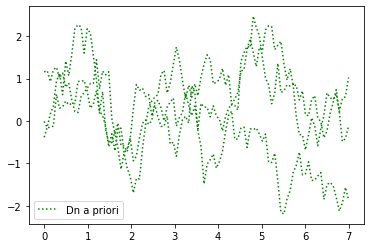

In [ ]:
#Gráfica de las dn´s a priori
#plt.plot(x, f, color="red", label="Función original")
plt.plot(x, priori1, color="green", label="Dn a priori", linestyle=":")
plt.plot(x, priori2, color="green", linestyle=":")
plt.plot(x, priori3, color="green", linestyle=":")

plt.legend()
plt.show()

#Dn posterior

In [ ]:
#Cálculo de los parámetros de la dn posterior utilizando los hiperparámetros iniciales

#Media posterior
m1=k(x,X).numpy()
m2=np.linalg.inv(k(X,X).numpy()+np.identity(num_train_data)*sigma)
m3=np.dot(m1,m2)
mean_posterior=np.dot(m3,Y).T[0]

#Varianza posterior
m4=k(x,x).numpy()
m5=k(X,x).numpy()
var_posterior=m4-np.dot(m3,m5)

#Simulación de 50 muestras de la posterior
YY=np.random.multivariate_normal(mean=mean_posterior.T,cov=var_posterior, size=50)


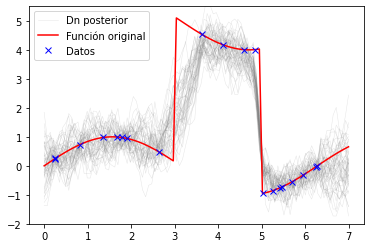

In [ ]:
#Gráficas de la dn posterior con la función original y los datos
plt.plot(x, YY.T, color="gray", linewidth=0.5, alpha=0.2)
plt.plot(x, YY.T[:,0], color="gray", label="Dn posterior",  linewidth=0.5, alpha=0.2)
plt.plot(x, f, color="red", label="Función original")
plt.plot(X, Y, "x", color="blue", label="Datos")
plt.legend()
plt.ylim(-2, 5.5)
plt.show()

#Predicción

In [ ]:
m = gpflow.models.GPR(data=(X, Y), kernel=k, mean_function=None)

In [ ]:
#Summary del modelo
m.likelihood.variance.assign(.1)
print_summary(m)

╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │   value │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════╡
│ GPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │     1   │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ GPR.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │     1   │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │     0.1 │
╘═════════════════════════╧═══════════╧══════════════════╧═════════╧═════════════╧═════════╧════

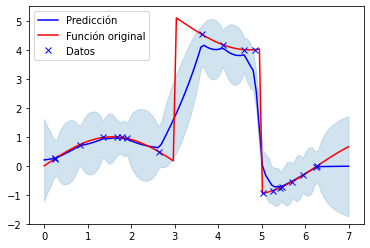

In [ ]:
#Predicción y_hat utilizando los hiperparámetros iniciales
mean, var = m.predict_f(x)
var=var+np.identity(len(var))*sigma
plt.plot(x, mean_posterior, color="blue", label="Predicción ")
plt.plot(x,f, color="red", label="Función original")
plt.plot(X, Y, "x", color="blue", label="Datos")
plt.fill_between(
    x[:, 0],
    mean[:, 0] - 1.96 * np.sqrt(var[:, 0]),
    mean[:, 0] + 1.96 * np.sqrt(var[:, 0]),
    color="C0",
    alpha=0.2,
)
plt.legend()
plt.ylim(-2, 5.5)
plt.show()

In [ ]:
#Valor de la -log verosimulitud
m.training_loss().numpy()

45.689034269131774

In [ ]:
#Puedo asignar valores iniciales
#m.likelihood.variance.assign(0.01)
#m.kernel.lengthscales.assign(1)

#Cálculo de hiperparámetros

In [ ]:
#Estimación de hiperparámetros por el método del gradiente
opt = gpflow.optimizers.Scipy()
opt_logs = opt.minimize(m.training_loss, m.trainable_variables, options=dict(maxiter=100))
print_summary(m)

╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │       value │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════════╡
│ GPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 4.82885     │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────┤
│ GPR.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 1.105       │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │ 1.05983e-06 │
╘═════════════════════════╧═══════════╧══════════════════╧══════

In [ ]:
#Estimación de los hiperparámetros
k

name,class,transform,prior,trainable,shape,dtype,value
Matern12.variance,Parameter,Softplus,,True,(),float64,4.82885
Matern12.lengthscales,Parameter,Softplus,,True,(),float64,1.105


Calculo nuevamente la posterior

In [ ]:
#calculo de los parámetros de la posterior con los hiperparámetros estimados
#Media posterior
k=m.kernel
sigma=m.likelihood.variance
m1=k(x,X).numpy()
m2=np.linalg.inv(k(X,X).numpy()+np.identity(num_train_data)*sigma)
m3=np.dot(m1,m2)
mean_posterior=np.dot(m3,Y).T[0]

#Varianza posterior
m4=k(x,x).numpy()
m5=k(X,x).numpy()
var_posterior=m4-np.dot(m3,m5)

YY=np.random.multivariate_normal(mean=mean_posterior.T,cov=var_posterior, size=50)

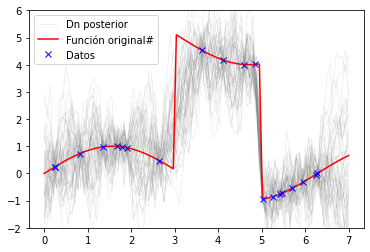

In [ ]:
#Gráficas de la dn posterior con la función original y los datos
plt.plot(x, YY.T, color="gray", linewidth=0.5, alpha=0.2)
plt.plot(x, YY.T[:,0], color="gray", label="Dn posterior",  linewidth=0.5, alpha=0.2)
plt.plot(x, f, color="red", label="Función original#")
plt.plot(X, Y, "x", color="blue", label="Datos")
plt.legend()
plt.ylim(-2, 6)
plt.show()

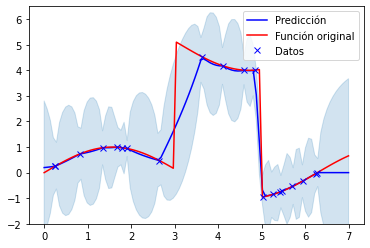

In [ ]:
#Predicción y_hat utilizando los hiperparámetros estimados
#Figura 2.11
mean, var = m.predict_f(x)
var=var+np.identity(len(var))*sigma
plt.plot(x, mean_posterior, color="blue", label="Predicción ")
plt.plot(x, f, color="red", label="Función original")
plt.plot(X, Y, "x", color="blue", label="Datos")
plt.fill_between(
    x[:, 0],
    mean[:, 0] - 1.96 * np.sqrt(var[:, 0]),
    mean[:, 0] + 1.96 * np.sqrt(var[:, 0]),
    color="C0",
    alpha=0.2,
)
plt.legend()
plt.ylim(-2,6.5)
plt.show()

In [ ]:
#Valor de la -log verosimulitud
m.training_loss().numpy()

32.146532199471814